# Librerias

In [1]:
import torch, random, math
import numpy as np
import pandas as pd
import torch.nn.functional as F
from tqdm import tnrange
from time import time
from torch import nn
from torchtext import data
from torch.autograd import Variable
from iseq2seq.utils import load_anki_dataset, write_training_log, write_training_loss, show_attn

import matplotlib.pyplot as plt
%matplotlib inline

# Cargar data

In [2]:
batch_size = 128
data_path = 'data/dataset.pkl'

ds_train, ds_test, ds_val, ES, EN = load_anki_dataset(data_path)
es_dict = {v:k for k,v in ES.vocab.stoi.items()}
en_dict = {v:k for k,v in EN.vocab.stoi.items()}

train_buckets = data.BucketIterator(ds_train, batch_size,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
test_buckets = data.BucketIterator(ds_test, batch_size,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
val_buckets = data.BucketIterator(ds_val, batch_size,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
train_iter = iter(train_buckets)
test_iter = iter(test_buckets)
val_iter = iter(val_buckets)
epoch_batchs_train = math.ceil(len(train_buckets.dataset.examples) / train_buckets.batch_size)
epoch_batchs_train

801

In [3]:
train_max_length = 0

for ex in train_buckets.dataset.examples:
    train_max_length = max(train_max_length, len(ex.en))
    
train_max_length

25

In [4]:
SOS_token = EN.vocab.stoi['<sos>']
EOS_token = EN.vocab.stoi['<eos>']
SOS_token, EOS_token

(2, 3)

# Cargar Embeddings (GloVe)

In [5]:
import spacy

spacy_es = spacy.load('es')
spacy_en = spacy.load('en')

def create_emb(lang_model, vocab, dim_vec):
    vocab_size = len(vocab.itos)
    emb = np.zeros((vocab_size, dim_vec))
    found = 0

    for i, word in enumerate(vocab.itos):
        w = lang_model(word)
        if w.has_vector:
            emb[i] = lang_model(word).vector
            found += 1
        else:
            # Si no se encuentra una palabra en los embeddings
            # entrenados, se usa un vector random.
            emb[i] = np.random.normal(scale=0.6, size=(dim_vec,))

    return torch.from_numpy(emb), found

emb_es, found_es = create_emb(spacy_es, ES.vocab, 50)
print('Spanish embeddings:', emb_es.shape, 'found:', found_es)
emb_en, found_en = create_emb(spacy_en, EN.vocab, 300)
print('English embeddings:', emb_en.shape, 'found:', found_en)

Spanish embeddings: torch.Size([10264, 50]) found: 10135
English embeddings: torch.Size([6548, 300]) found: 4574


# MODELS:

In [6]:
def load_emb(emb_mat):
    output_size, emb_size = emb_mat.size()
    emb = nn.Embedding(output_size, emb_size)
    emb.load_state_dict({'weight': emb_mat})

    return emb

# Encoder

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False,
                 embedding_dropout=0.1, rnn_dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout
        
        # Layers
        self.embedding = load_emb(emb_es)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.lineal = nn.Linear(50, hidden_size) # 50 word_vec spanish
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=n_layers,
                          bidirectional=bidirectional, dropout=rnn_dropout)
        
    def forward(self, input, hidden):
        embs = self.embedding(input)
        embs = self.embedding_dropout(embs)
        embs = self.lineal(embs)
        output, hidden = self.rnn(embs, hidden)
        if self.bidirectional:
            # En caso el encoder sea bidireccional, se suman los outputs
            # en vez de concatenarlos.
            output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
        
        return output, hidden

# Attention Decoder

In [8]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        # metodos definidos en https://arxiv.org/pdf/1508.04025.pdf
        assert method in ('dot', 'general', 'concat'), 'invalid attention method'
        
        # Layers
        if self.method == 'general':
            self.att = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.att = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Se inicializa las energias de atencion y se calculan en cada elemento del batch
        att_energies = Variable(torch.zeros(this_batch_size, max_len)).cuda()

        for b in range(this_batch_size): # por cada elemento b del batch
            for i in range(max_len): # por cada paso i de la secuencia
                att_energies[b, i] = self.score(hidden[:, b].squeeze(0),
                                                encoder_outputs[i, b])

        # Se normalizan los pesos entre 0 y 1
        return F.softmax(att_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.att(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.att(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

class AttnDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, n_layers=1,
                 att_method='general', embedding_dropout=0.1, rnn_dropout=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.att_method = att_method
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout

        # Layers
        self.embedding = load_emb(emb_en)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=rnn_dropout)
        self.attention = Attention(att_method, hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, last_hidden, encoder_outputs):
        # ojo: input es el batch de los ultimos outputs, no es una secuencia
        batch_size = input.size(0)
        embs = self.embedding(input)
        embs = self.embedding_dropout(embs)
        embs = embs.view(1, batch_size, self.hidden_size)

        # Se corre la RNN en el input con el ultimo hidden state
        rnn_output, hidden = self.rnn(embs, last_hidden)
        
        # Se calcula la atencion y se aplica a las salidas del encoder
        att_weights = self.attention(rnn_output, encoder_outputs)
        context = att_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # Se concatenan los valores de salida de la rnn y el contexto
        concat_input = torch.cat((rnn_output.squeeze(0), context.squeeze(1)), 1)
        concat_output = F.tanh(self.concat(concat_input))
        output = self.out(concat_output)

        return output, hidden, att_weights
    

# Training

In [9]:
def train_epoch(epoch_desc, epoch_batchs, tf_ratio, gradient_clip=5.0, data_set='train',
                tqdm_enable=True):
    avg_mom = 0.9
    avg_loss = 0.0
    debias_loss = 0.0
    
    if data_set == 'train':
        encoder.train(True)
        decoder.train(True)
    else:
        encoder.train(False)
        decoder.train(False)
    
    if not tqdm_enable:
        range_fun = range(epoch_batchs)
    elif data_set == 'train':
        range_fun = tnrange(epoch_batchs, desc=epoch_desc)
    else:
        range_fun = tnrange(epoch_batchs, desc=epoch_desc, leave=False)
    
    for it in range_fun:
        if tqdm_enable:
            range_fun.set_postfix(loss=debias_loss, teacher_forcing=tf_ratio)
        
        # Inicializar gradientes y perdida
        if data_set == 'train':
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
        # Obtener batch de entrenamiento
        if data_set == 'train':
            training_batch = next(train_iter)
        elif data_set == 'test':
            training_batch = next(test_iter)
        elif data_set == 'validation':
            training_batch = next(val_iter)
            
        input_variable = training_batch.es
        target_variable = training_batch.en
        input_length, batch_size  = input_variable.size()
        target_length = target_variable.size()[0]

        # Encodear el input
        encoder_outputs, encoder_hidden = encoder(input_variable, None)

        # Crear variables para el input y output del decoder
        decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).cuda()
        # Fix, las ultimas capas en caso de bidireccional
        decoder_hidden = encoder_hidden[-decoder.n_layers:]
        all_decoder_outputs = Variable(torch.zeros(
            target_length, batch_size, decoder.output_size)).cuda()

        # Se ejecuta el decoder en cada paso de la secuencia
        for t in range(target_length):
            decoder_output, decoder_hidden, decoder_att = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            all_decoder_outputs[t] = decoder_output

            if t < target_length-1:
                # Usar teacher_forcing
                use_tf = random.random() < tf_ratio
                if use_tf:
                    # De la data
                    decoder_input = target_variable[t+1]
                else:
                    # Del modelo
                    decoder_input = decoder_output.topk(1, 1)[1]

        # Funcion de perdida
        log_probs = F.log_softmax(all_decoder_outputs.view(-1, decoder.output_size))
        loss = nn.NLLLoss()(log_probs, target_variable.view(-1))
        avg_loss = avg_loss * avg_mom + loss.data[0] * (1-avg_mom)
        debias_loss = avg_loss / (1 - avg_mom**(it+1))
        write_training_loss(f'data/{model_name}_loss.csv', loss.data[0])
        
        # Optimizar parametros
        if data_set == 'train':             
            loss.backward()
            nn.utils.clip_grad_norm(encoder.parameters(), gradient_clip)
            nn.utils.clip_grad_norm(decoder.parameters(), gradient_clip)
            encoder_scheduler.step()
            decoder_scheduler.step()
    
    return avg_loss if it > 100 else debias_loss


In [10]:
def predict(batch, max_target_length=train_max_length):
    input_length, batch_size  = batch.size()
    target_length = min(train_max_length, input_length*2)
    eos_check = torch.LongTensor([EOS_token] * batch_size).cuda()
    outputs = []
    attn = []
    done = set()
    
    # Encodear el input
    encoder_outputs, encoder_hidden = encoder(batch, None)

    # Crear variables para el input y output del decoder
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).cuda()
    # Fix, las ultimas capas en caso de bidireccional
    decoder_hidden = encoder_hidden[-decoder.n_layers:]

    # Se ejecuta el decoder en cada paso de la secuencia
    for t in range(target_length):
        decoder_output, decoder_hidden, decoder_att = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        if t < target_length-1:
            # Nuevos inputs en la secuencia
            decoder_input = decoder_output.topk(1, 1)[1]
            outputs.append(decoder_input)
            attn.append(decoder_att)
            # Validar elementos del batch que hallan acabado (EOS)
            step_eos = decoder_input.data.cpu().numpy() == EN.vocab.stoi['<eos>']
            eos_idxs = np.where(step_eos)[0]
            for idx in eos_idxs: done.add(idx)
        
        if len(done) == batch_size:
            # Si todo el batch tiene eos terminar
            break
            
    
    outputs = torch.cat(outputs, 1).transpose(0, 1).data.cpu().numpy() # output_seq x batch_size
    attn = torch.cat(attn, 1).data.cpu().numpy() # batch_size x output_seq x input_seq
    
    return outputs, attn

In [11]:
perplexity = lambda x: math.exp(float(x)) if x < 300 else float("inf")

def train(epochs, model_name, tf_ratio=1.0, tf_epoch_end=0, results_each=5,
          n_examples=3, save_each=5, epoch_batchs_test=10, gradient_clip=5.0):
    t0 = time()
    results = {}
    train_loss = []
    test_loss = []
    zeros = int(math.log10(epochs)) + 1
    
    # teacher forcing interpolation
    tf = np.zeros(epochs)
    tf[:tf_epoch_end] = np.linspace(tf_ratio, 0, tf_epoch_end)
    
    try:
        for i in tnrange(epochs, desc='Training'):
            # Entrenar una epoca
            l = train_epoch(f'Epoch {i+1:0{zeros}}', epoch_batchs_train,
                            tf[i], gradient_clip)
            train_loss.append(l)

            # Evaluar perdida en el test set (sin teacher forcing)
            l = train_epoch(f'Test Loss', epoch_batchs_test,
                            0, gradient_clip, data_set='test')
            test_loss.append(l)

            # Guardar modelo
            if (i+1) % save_each == 0:
                torch.save(encoder.state_dict(), f'data/{model_name}_encoder.pkl')
                torch.save(decoder.state_dict(), f'data/{model_name}_decoder.pkl')

            # Mostrar resultados
            if (i+1) % results_each == 0:
                print('Teacher forcing ratio=%.2f' % tf[i])
                print('Train loss=%.5f, perplexity=%.5f' %
                      (train_loss[-1], perplexity(train_loss[-1])))
                print('Test  loss=%.5f, perplexity=%.5f\n' %
                      (test_loss[-1], perplexity(test_loss[-1])))

                # Ejemplos de traduccion
                examples = next(train_iter)
                examples_es = examples.es[:,:n_examples]
                examples_en = examples.en[:,:n_examples].data.cpu().numpy()
                predicted, _ = predict(examples_es)
                examples_es = examples_es.data.cpu().numpy()
                for j in range(n_examples):
                    print(' '.join([es_dict[w] for w in examples_es[:, j]]))
                    print('Result -> ', ' '.join([en_dict[w] for w in predicted[:, j]]))
                    print('Target -> ', ' '.join([en_dict[w] for w in examples_en[:, j]]), '\n')
        
            write_training_log(f'data/{model_name}_log.csv', i+1,
                               tf[i], train_loss[-1], test_loss[-1])
            
    except KeyboardInterrupt:
        print('Interrupted at epoch: %d' % (i+1))
        
    results['train_loss'] = train_loss
    results['test_loss'] = test_loss
        
    torch.save(encoder.state_dict(), f'data/{model_name}_encoder.pkl')
    torch.save(decoder.state_dict(), f'data/{model_name}_decoder.pkl')
    
    return results

# Definir el modelo

In [12]:
model_name = 'seq2seq'
encoder_hidden = 300 # Tamaño de los vectores GloVe
encoder_bi = True
n_layers = 2
lr = 0.001
teacher_forcing_epoch_end = 5
epochs = 10

encoder = EncoderRNN(len(ES.vocab.itos), encoder_hidden, n_layers, bidirectional=encoder_bi).cuda()
decoder = AttnDecoderRNN(len(EN.vocab.itos), encoder_hidden, n_layers).cuda()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
encoder_scheduler, decoder_scheduler = encoder_optimizer, decoder_optimizer
print(encoder); print(decoder)

EncoderRNN (
  (embedding): Embedding(10264, 50)
  (embedding_dropout): Dropout (p = 0.1)
  (lineal): Linear (50 -> 300)
  (rnn): GRU(300, 300, num_layers=2, dropout=0.1, bidirectional=True)
)
AttnDecoderRNN (
  (embedding): Embedding(6548, 300)
  (embedding_dropout): Dropout (p = 0.1)
  (rnn): GRU(300, 300, num_layers=2, dropout=0.1)
  (attention): Attention (
    (att): Linear (300 -> 300)
  )
  (concat): Linear (600 -> 300)
  (out): Linear (300 -> 6548)
)


In [13]:
# Cargar pesos
encoder.load_state_dict(torch.load(f'data/{model_name}_encoder.pkl'))
decoder.load_state_dict(torch.load(f'data/{model_name}_decoder.pkl'))

# Entrenamiento

In [13]:
results = train(epochs, model_name, tf_epoch_end=teacher_forcing_epoch_end, save_each=1)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Teacher forcing ratio=0.00
Train loss=2.66673, perplexity=14.39279
Test  loss=2.36533, perplexity=10.64756

¿ por qué debería preocuparme de qué hace tom ?
Result ->  <sos> why should you you what tom tom ? <eos> <eos>
Target ->  <sos> why should i care what tom does ? <eos> <pad> 

¿ cuál es tu canción de rock <unk> favorita ?
Result ->  <sos> what 's your favorite a a ? <eos> <eos> <eos>
Target ->  <sos> what is your favorite <unk> rock song ? <eos> <pad> 

deberíamos estar en chicago para la hora de comer .
Result ->  <sos> we should be in to the the . . <eos>
Target ->  <sos> we should get to chicago by lunchtime . <eos> <pad> 



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Teacher forcing ratio=0.00
Train loss=2.23930, perplexity=9.38680
Test  loss=2.01796, perplexity=7.52297

los padres de tom <unk> que mary era demasiado mayor para él .
Result ->  <sos> tom 's parents heard mary was too for for for for for for <pad> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target ->  <sos> tom 's parents thought that mary was too old for him . <eos> <pad> <pad> <pad> 

vuelve antes de la medianoche o te vas a quedar encerrado afuera .
Result ->  <sos> go until until the the , you . you . . <eos> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target ->  <sos> get back before midnight , or you will be locked out . <eos> <pad> <pad> <pad> 

cuando llegaron a la estación , el tren ya se había ido .
Result ->  <sos> when he arrived to train train train train train . . . <eos> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target ->  <sos> when they got to the station , the train had already left . <eos> <pad> <pad> 




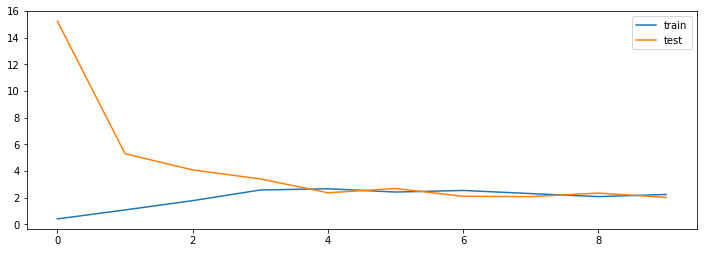

In [32]:
plt.figure(figsize=(12,4))
plt.plot(results['train_loss'], label='train')
plt.plot(results['test_loss'], label='test')
plt.legend();

# Beam Search

In [91]:
def predict_beamsearch(input_word, encode=False, beams=3, max_target_length=train_max_length):
    if encode:
        input_word = [ES.vocab.stoi[t] for t in ES.tokenize(input_word)]
        input_word = Variable(torch.LongTensor(input_word).unsqueeze(1)).cuda()
    
    route = []
    input_length, v = input_word.size()
    assert v == 1, 'Only 1 word atm'
    
    target_length = min(train_max_length, input_length*2)
    encoder_outputs, encoder_hidden = encoder(input_word, None)
    decoder_input = Variable(torch.LongTensor([SOS_token])).cuda()
    decoder_hidden = encoder_hidden[-decoder.n_layers:]
    outputs = decoder_input.repeat(beams,1)
    eos_check = torch.LongTensor([EOS_token] * batch_size).cuda()

    scores, decoder_input, decoder_hidden, attn, keep = get_beam(
        decoder_input, decoder_hidden, encoder_outputs, beams, None, True)
    route.append(keep)
    
    for t in range(target_length-1):
        scores, decoder_input, decoder_hidden, att, keep = get_beam(
            decoder_input, decoder_hidden, encoder_outputs, beams, scores)
        route.append(keep.data.tolist())
        attn = torch.cat([attn[keep/beams],att],1)
        outputs = torch.cat([outputs[keep/beams],decoder_input.unsqueeze(1)],1)
        if torch.sum(torch.sum(outputs == 3, 1) > 0).data[0] == beams: break
        
    outputs = outputs.data.cpu().numpy()
    attn = attn.data.cpu().numpy()
    scores = scores.data.tolist()
    route = np.array(route).transpose()
    
    return outputs, attn, scores, route

def get_beam(decoder_input, decoder_hidden, encoder_outputs,
             beams, p_scores, first=False):
    if not first:
        encoder_outputs = encoder_outputs.repeat(1,beams,1)
    
    decoder_output, decoder_hidden, decoder_att = decoder(
        decoder_input, decoder_hidden, encoder_outputs
    )
    scores, decoder_input = decoder_output.topk(beams, 1)
    
    if first:
        decoder_hidden = decoder_hidden.repeat(1,beams,1)
        decoder_att = decoder_att.repeat(beams,1,1)
        keep = [0]*beams
    else:
        # manter los top beam resultados
        scores = scores + p_scores.unsqueeze(1)
        scores, keep = scores.view(-1).topk(beams)
        decoder_att = decoder_att[keep/beams]
        decoder_hidden = decoder_hidden[:,(keep/beams).data.tolist(),:]
        decoder_input = decoder_input.view(-1)[keep]
        
    scores = scores.view(-1)
    decoder_input = decoder_input.view(-1)
    
    return scores, decoder_input, decoder_hidden, decoder_att, keep

## Beam test

In [15]:
val_buckets = data.BucketIterator(ds_val, 1,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
val_iter = iter(val_buckets)

In [32]:
example = next(val_iter)
example_es = example.es
example_en = example.en.data.cpu().numpy()
outputs, attn, scores, _ = predict_beamsearch(example_es, beams=5)
example_es = example_es.data.cpu().numpy()
ex = [es_dict[w] for w in example_es[:, 0]]
ex_target = [en_dict[w] for w in example_en[:, 0]]

for i, (o, s) in enumerate(zip(outputs, scores)):
    print('Beam %d (%.2f):' % (i+1, s))
    ex_result = [en_dict[w] for w in o]
    print('Source:', ' '.join(ex))
    print('Target:', ' '.join(ex_target))
    print('Result:', ' '.join(ex_result))

Beam 1 (118.54):
Source: ¿ qué intenta esconder ?
Target: <sos> what are you trying to hide ? <eos>
Result: <sos> which needs trying to hide ? <eos> <eos>
Beam 2 (118.50):
Source: ¿ qué intenta esconder ?
Target: <sos> what are you trying to hide ? <eos>
Result: <sos> which needs to hide to ? <eos> <eos>
Beam 3 (118.44):
Source: ¿ qué intenta esconder ?
Target: <sos> what are you trying to hide ? <eos>
Result: <sos> which needs to hide to ? ? <eos>
Beam 4 (118.33):
Source: ¿ qué intenta esconder ?
Target: <sos> what are you trying to hide ? <eos>
Result: <sos> which needs trying to hide ? ? <eos>
Beam 5 (118.32):
Source: ¿ qué intenta esconder ?
Target: <sos> what are you trying to hide ? <eos>
Result: <sos> what could to hide to ? <eos> <eos>


# Ver resultados

Source: tom vio a mary llorando .
Target: <sos> tom saw mary crying . <eos>
Result: <sos> tom saw mary crying . <eos> <eos>


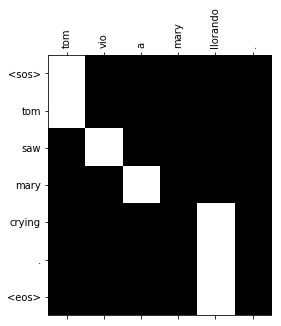

Source: él necesita una salida más <unk> para su <unk> .
Target: <sos> he needs a more productive <unk> for his anger . <eos>
Result: <sos> he needs some <unk> more his his his his his . <eos> <eos> <pad>


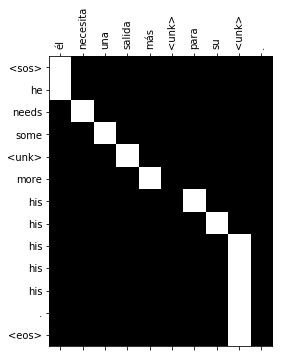

Source: esperé en vano toda la tarde .
Target: <sos> i waited all afternoon in vain . <eos>
Result: <sos> i waited for the all the . . . <eos> <eos>


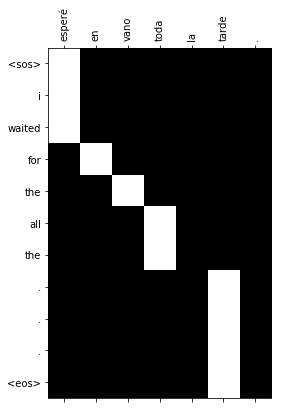

In [38]:
beams = 5
examples = 3

for _ in range(examples):
    example = next(val_iter)
    example_es = example.es
    example_en = example.en.data.cpu().numpy()
    outputs, attn, *_ = predict_beamsearch(example_es, beams=5)
    example_es = example_es.data.cpu().numpy()
    ex = [es_dict[w] for w in example_es[:, 0]]
    ex_target = [en_dict[w] for w in example_en[:, 0]]
    ex_result = [en_dict[w] for w in outputs[0]]
    print('Source:', ' '.join(ex))
    print('Target:', ' '.join(ex_target))
    print('Result:', ' '.join(ex_result))
    show_attn(attn[0], ex, ex_result)

# Probar

Source: ¿qué hora es?
Result: <sos> what time is it ? <eos> <eos>


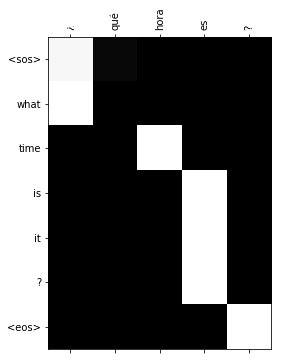

In [113]:
sentence = '¿qué hora es?'
outputs, attn, *_ = predict_beamsearch(sentence, beams=5, encode=True)
ex_result = [en_dict[w] for w in outputs[0]]
print('Source:', sentence)
print('Result:', ' '.join(ex_result))
show_attn(attn[0], ES.tokenize(sentence), ex_result)